# Imports

In [1]:
# ! pip install pandas-profiling
! pip install geopandas
# ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
! pip install pandas
# ! pip install pandas==0.25
! pip install tensorflow_text
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
  Attempting uninstall: click
    Found existing installation: click 8.0.1
    Uninstalling click-8.0.1:
      Successfully uninstalled click-8.0.1
  Using cached tensorflow_text-2.5.0-cp39-cp39-macosx_10_9_x86_64.whl (3.6 MB)


In [4]:
# 'imports; megabytes of imports'  - Johnny 5
import pandas as pd
import numpy as np
# from google.colab import files
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime
import geopandas as gpd
import os
import re
import shutil
import string
import operator
import pathlib


import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_text as tf_text
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split,cross_val_score,  GridSearchCV
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

ModuleNotFoundError: No module named 'google.colab'

In [ ]:


from google.colab import drive
drive.mount('/content/drive')
 




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import dataset
tdata = pd.read_csv('/content/drive/MyDrive/globalterrorismdb_0718dist.csv', engine='python')
tdata.set_index('eventid')
pd.options.display.max_columns = 40
pd.options.display.max_rows = 200

In [ ]:
# pandas_profiling.ProfileReport(tdata)

# Data EDA and Cleaning

In [ ]:
# columns that can be removed: 
out_columns =  ['weapsubtype1', 'weaptype1', 'claimed',   'nperpcap', 'nwoundus', 'propvalue', 'propcomment', 'addnotes', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related',  'property',  'propextent','nperps', 'natlty1', 'targsubtype1','motive','dbsource','approxdate' , 'extended' , 'resolution' , 'vicinity' , 'location' , 'alternative', 'alternative_txt', 'multiple', 'attacktype2', 'attacktype2_txt' , 'attacktype3' ,'attacktype3_txt' ,'targtype2' ,	'targtype2_txt' , 	'targsubtype2'	, 'targsubtype2_txt' ,	'corp2' , 	 'target2',	'natlty2',	'natlty2_txt','targtype3',	'targtype3_txt',	'targsubtype3',	'targsubtype3_txt',	'corp3',	'target3',	'natlty3',	'natlty3_txt',	'gsubname',	'gname2',	'gsubname2',	'gname3',	'gsubname3',	'guncertain2',	'guncertain3', 'claimmode',	'claimmode_txt',	'claim2',	'claimmode2',	'claimmode2_txt','claim3',	'claimmode3',	'claimmode3_txt',	'compclaim', 'weaptype2',	'weaptype2_txt',	'weapsubtype2',	'weapsubtype2_txt',	'weaptype3', 'weapsubtype3',	'weapsubtype3_txt', 'weaptype4','weaptype4_txt',	'weapsubtype4',	'weapsubtype4_txt', 'nkillus',	'nkillter',	'nwound',	'nwoundte', 'ishostkid',	'nhostkid',	'nhostkidus',	'nhours',	'ndays',	'divert', 'kidhijcountry',	'ransom',	'ransomamt',	'ransomamtus',	'ransompaid',	'ransompaidus',	'ransomnote',	'hostkidoutcome',	'hostkidoutcome_txt', 'nreleased', 'weaptype3_txt' ]

tdata = tdata.drop(columns = out_columns) 


In [ ]:

counts = tdata['gname'].value_counts()

tdata = tdata[tdata['gname'].isin(counts[counts > 400].index)]
counts = tdata['gname'].value_counts()
print(counts)

TypeError: ignored

In [ ]:
# tdata.isnull().sum().head(5)
tdata.fillna('', inplace=True)



In [ ]:
tdata.drop(tdata[tdata['summary'] == ''].index, inplace = True)


In [ ]:

tdata['summary']= tdata['summary'].str.replace('\d+', '')
tdata['summary']= tdata['summary'].str.replace('[^\w\s]', '')

In [ ]:

df= tdata.copy()
df.head(2)


In [ ]:
# df.isnull().sum()

In [ ]:
# data to predict on after training
need_predict = df[df['gname'] == 'Unknown']
need_predict.shape

In [ ]:
#remove prediction data from main dataframe
df.drop(df[df['gname'] == 'Unknown'].index, inplace = True)


In [ ]:
# reported groups
len(df.gname.value_counts())

In [ ]:
#create 10% holdback tp verify multiple models. 
#Don't touch until end!
hold_back = df.sample(frac = 0.1)
#hold_back.shape

In [ ]:
df = df.drop(hold_back.index)
df.shape

# Visuals

Top 30 active Terrorist Groups

In [ ]:
Groups = df['gname'].value_counts()
GroupList = sorted(list(zip(Groups.values[:35],Groups.index[:35])),reverse=True)
MostActive, Counts = zip(*GroupList)
MostActive, Counts = list(MostActive), list(Counts)

fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(x=MostActive, y=Counts, palette='icefire_r' )
# sns.barplot(x=Counts,y=MostActive)
ax.set_title('Most Active Terrorist Groups', fontsize=18)
plt.xlabel("Attacks", fontsize=15)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.yticks(fontsize=13)
plt.xticks(np.arange(0, 7001, 200), rotation=60, fontsize=13)
fig.patch.set_facecolor('aliceblue')
ax.set_facecolor('aliceblue')

plt.show()

Total Attacks vs Year



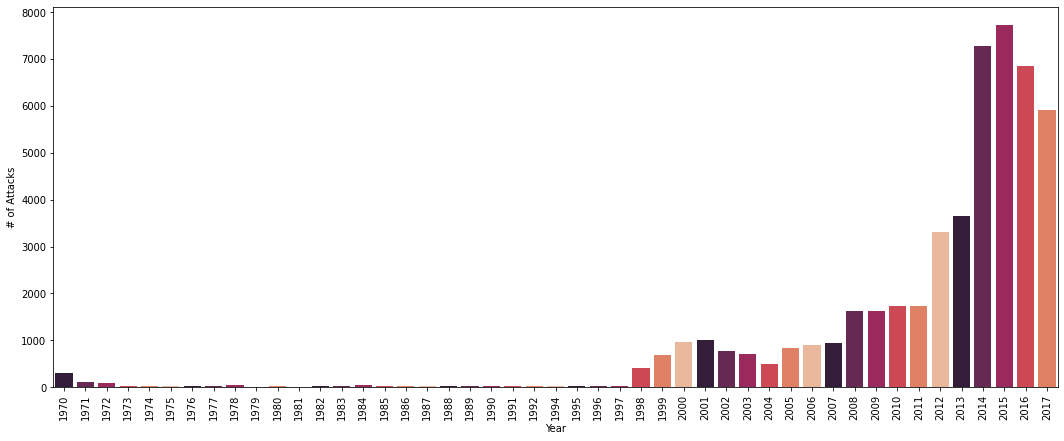

In [ ]:
dfYear = list(zip(df.iyear.value_counts().index,df.iyear.value_counts().values))
dfYear = sorted(dfYear)
terrorByYear = []
terrorByCounts = []
for i in dfYear:
    terrorByYear.append(i[0])
    terrorByCounts.append(i[1])

plt.figure(figsize=(18,7))
sns.barplot(x=terrorByYear,y=terrorByCounts,palette=sns.color_palette("rocket"))
plt.xticks(rotation=90)
plt.xlabel("Year")
plt.ylabel("# of Attacks")
plt.show()

Attacks By Year and Region

In [ ]:
regionYear = pd.crosstab(df.iyear,df.region_txt)
regionYear.plot(color=sns.color_palette("bright",12),grid=True)
figure=plt.gcf()
figure.set_size_inches(20,8)
plt.xlabel("Year")
plt.ylabel("# of Attacks")
plt.title("Attacks by Year and Region")
plt.show()

TypeError: ignored

Heat Map

In [ ]:
# country = tdata['country_txt']
# country_weapon = tdata.groupby(by='weaptype1_txt', as_index=False).count().sort_values(by='eventid',ascending=False).iloc[:,:2]
                                                  
                                                                                                                
# sns.barplot(x='weaptype1_txt', y='eventid', data=country_weapon, ax=ax, ci=None)
# ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=90)
# ax[1, 1].set_xlabel('')
# ax[1, 1].set_ylabel('Count')
# format_spines(ax[1, 1], right_border=False)
# ax[1, 1].set_title(f'{country_name} Weapons Used in Attacks')

# plt.suptitle(f'Terrorism Analysis in {country_name} between 1970 and 2017', size=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.90)
# plt.show()

In [ ]:
# pandas_profiling.ProfileReport(df)

# Models

In [ ]:
#create train test split from df
y = df['gname']
X = df.drop(columns= ['eventid','longitude', 'latitude', 'gname'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

## Tensorflow

In [ ]:
data = df[['summary', 'gname']]
ds = tf.data.Dataset.from_tensor_slices(dict(data))

train, test = train_test_split(data, test_size=0.4)
test, val = train_test_split(test, test_size=0.5)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')
print(len(data))

In [ ]:
data = df[['summary', 'gname']]
# ds = tf.data.Dataset.from_tensor_slices(dict(data))

# train, test = train_test_split(data, test_size=0.4)
# test, val = train_test_split(test, test_size=0.5)
# print(len(train), 'train examples')
# print(len(val), 'validation examples')
# print(len(test), 'test examples')
# print(len(data))

# train_ds = tf.data.Dataset.from_tensor_slices((train['summary'].values, train['gname'].values))
# train_ds= tf.data.Dataset.from_tensor_slices(dict(train))
# val_ds= tf.data.Dataset.from_tensor_slices(dict(val))
# test_ds = tf.data.Dataset.from_tensor_slices(dict(test))
# train_ds = tf.data.Dataset.from_tensor_slices((train['summary'].values, train['gname'].values))
# print(train)

# max_features = 23502
# max_len  = 150
# embedding_dims = 100
# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, lower=True)
# GLOVE_EMBEDDING =  "glove.6B.100d.txt"



In [ ]:
#Data prep
# x_train = train['summary'].str.lower()
# y_train = train['gname'].values

In [ ]:
# tokenizer.fit_on_texts(x_train)

# x_train =tokenizer.texts_to_sequences(x_train)
# x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)

In [ ]:
# #create embedding matrix
# embeddings_index = {}

# with open(GLOVE_EMBEDDING, encoding='utf8') as f:
#     for line in f:
#         values = line.rstrip().rsplit(' ')
#         word = values[0]
#         embed = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = embed

# word_index = tokenizer.word_index

# num_words = min(max_features, len(word_index) + 1)

# embedding_matrix = np.zeros((num_words, embedding_dims), dtype='float32')

# for word, i in word_index.items():

#     if i >= max_features:
#         continue

#     embedding_vector = embeddings_index.get(word)

#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

In [ ]:
# input = tf.keras.layers.Input(shape=(max_len,))

# x = tf.keras.layers.Embedding(max_features, embedding_dims, weights=[embedding_matrix], trainable=False)(input)

In [ ]:
# #Biderictional Layer

# x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)

# x = tf.keras.layers.Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)

# avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)

# max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)

# x = tf.keras.layers.concatenate([avg_pool, max_pool])

# preds = tf.keras.layers.Dense(6, activation="sigmoid")(x)

# x.summary()

# model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-3), metrics=['accuracy'])


In [ ]:
# x_train

In [ ]:
#convert the pandas object to a tensor
# train=tf.convert_to_tensor(train)
# type(data)
# train_data, test_data = tfds(train, split=["train", "test"], 
#                                   batch_size=-1, as_supervised=True)
# train_ds = tf.constant(([train['summary'], train['gname']]))
# x_train= tf.data.Dataset.from_tensor_slices(dict(x_train))
# train_examples, train_labels = tfds.as_numpy(x_train)

In [ ]:
# for feat, targ in train.take(5):
#   print ('Features: {}, Target: {}'.format(feat, targ))

In [ ]:
# embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")
# embeddings = embed(train_examples)

In [ ]:
# print(embeddings.shape, embeddings.dtype)

In [ ]:
# # build a model
# model = tf.keras.Sequential()
# model.add(hub_layer)
# model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(1))

# model.summary()

In [ ]:
# # loss function and optimizer

# model.compile(optimizer = 'adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
# mod_train = model.fit()(train_data.shuffle(10000).batch(512), 
#                         epochs =10
#                         validation_data = validation_data.batch(512),
#                         verbose=1)

In [ ]:
# results = model.evaluate(test_data.batch(512), verbose=2)

# for name, value in zip(model.metric_names, results):
#     print("%s: %.3f" % (name, value))

## Random Forest 

In [ ]:

rfd = X_train['summary']
pred_rfd = X_test['summary']
y_train = y_train
y_test = y_test
#vectorize summary data
vectorizer = CountVectorizer(lowercase=True, stop_words='english', max_features = 4000)
vectorizer.fit(rfd)

RFX_train = vectorizer.transform(rfd)
RFX_test = vectorizer.transform(pred_rfd)


In [ ]:
RFX_train.shape

# 4000 - 0.7897053195560658

In [ ]:
RFC = RandomForestClassifier(n_estimators=110, max_depth=50)

RFC.fit(RFX_train, y_train)

In [ ]:
pred = RFC.predict(RFX_test)

In [ ]:
print('Accuracy:', metrics.accuracy_score(y_test, pred))

In [ ]:
# RFC.predict()

In [ ]:
parameters = {'max_depth' : np.arange(1, 12),
             'min_samples_leaf' : np.arange(5,95,10)}
             
scorer = make_scorer(log_loss,
                     greater_is_better=False,
                     needs_proba=True)
clf = GridSearchCV(RFC,
                   parameters,
                   cv=10,
                   scoring=scorer).fit(RFX_train,y_train)



In [ ]:
# Train and fit model                                                   
# rf = RandomForestClassifier(n_estimators=1000,
#                            max_features='auto',
#                            random_state=0)
# rf.fit(RFX_train, y_train)
                                     
# Test Prediction
# pred = rf.predict(RFX_test)

print(f"accuracy = {RFC.score(RFX_test, y_test):.3f}")

cm = confusion_matrix(y_test, pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

## Multinomial Naive Bayes Classifier 

In [ ]:

nbd_train = X_train['summary']
nbd_test = X_test['summary']
nby_train = y_train
nby_test = y_test


#vectorize summary data and transform to document term matrix
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
vectorizer.fit(nbd_train)

nbd_train_dtm = vectorizer.transform(nbd_train)

In [ ]:
# #check out data
# vectorizer.get_feature_names()

In [ ]:
# prep test data
nbd_test_dtm = vectorizer.transform(nbd_test)
nbd_test_dtm

In [ ]:
#finally get to build the model
nb=MultinomialNB()


%time nb.fit(nbd_train_dtm, nby_train )

In [ ]:
# make presiction with test data
prediction = nb.predict(nbd_test_dtm)

In [ ]:
metrics.accuracy_score(nby_test, prediction)

In [ ]:
# examine class distribution
print(y_test.value_counts())
# there is a majority class of 0 here, hence the classes are skewed

# calculate null accuracy (for multi-class classification problems)
# .head(1) assesses the value 1208
null_accuracy = y_test.value_counts().head(1) / len(y_test)
print('Null accuracy:', null_accuracy)

# Manual calculation of null accuracy by always predicting the majority class
print('Manual null accuracy:',(1208 / (1208 + 185)))

In [ ]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

In [ ]:
# print message text for the false positives (ham incorrectly classified as spam)

X_test[y_pred_class > y_test]

# alternative less elegant but easier to understand
# X_test[(y_pred_class==1) & (y_test==0)]

In [ ]:
# print message text for the false negatives (spam incorrectly classified as ham)

X_test[y_pred_class < y_test]
# alternative less elegant but easier to understand
# X_test[(y_pred_class=0) & (y_test=1)]


In [ ]:

# example false negative
X_test[3132]

In [ ]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)

# Numpy Array with 2C
# left Column: probability class 0
# right C: probability class 1
# we only need the right column 
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

# Naive Bayes predicts very extreme probabilites, you should not take them at face value

In [ ]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)
# AUC is useful as a single number summary of classifier performance
# Higher value = better classifier
# If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a higher predicted probability to the positive observation
# AUC is useful even when there is high class imbalance (unlike classification accuracy)
# Fraud case
# Null accuracy almost 99%
# AUC is useful here

NLP

In [ ]:
# temp_corpus = X['summary'].dropna()
# corpus = temp_corpus.apply(lambda x: x.split(': ')[-1]).values
# # print(f'We have {len(corpus)} elements on the corpus\n\n')
# # print(f'Example 1: \n{corpus[1]}\n')
# # print(f'Example 2: \n{corpus[-1]}')

# corpus

In [ ]:
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.ensemble import RandomForestRegressor
# from scipy.stats import zscore
# from sklearn.cluster import DBSCAN
# from sklearn.covariance import EllipticEnvelope
# from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.preprocessing import LabelEncoder
# from sklearn.svm import OneClassSVM
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import pie
# %matplotlib inline
# import time
# import pandas_profiling
# import warnings
# warnings.filterwarnings("ignore")
# from sklearn.model_selection import train_test_split
# from sklearn.feature_selection import f_classif
# from xgboost import XGBClassifier
# from hyperopt import hp,Trials,fmin,tpe